In [27]:
import torch
import json
from safetensors.torch import load_file
from transformers import ViTForImageClassification, ViTConfig
import os
from torchvision import transforms
from PIL import Image
import numpy as np
import importlib
from sklearn.metrics import classification_report


# define class list
class_list = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

TARGET_SIZE = (224,224)

NUM_CLASSES = len(class_list)



In [2]:

# mount google drive where preprocessed images are
# Mount drive and download data from EDA step 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# setup virtual directories
VDIR_PROJECT = '/content/skin_cancer'
VDIR_PROJECT_TRAIN_VAL_SET = VDIR_PROJECT+'/train_val_set'
VDIR_PROJECT_TESTSET = VDIR_PROJECT+'/test_set'
VDIR_PROJECT_MODELS = VDIR_PROJECT+'/models'
VDIR_PROJECT_MODELS_VIT = VDIR_PROJECT_MODELS+'/vit'
os.makedirs(VDIR_PROJECT_TRAIN_VAL_SET, exist_ok=True)
os.makedirs(VDIR_PROJECT_TESTSET, exist_ok=True)
os.makedirs(VDIR_PROJECT_MODELS, exist_ok=True)

# define source directories from Gdrive
GDIR_PROJECT_EDA_S1 = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/EDA_PrePro/S1'
GDIR_PROJECT_MODELS_VIT = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Training/models/VIT'

# COPY S1 images with no augmentation. Only validation set is needed for evaluation
GDIR_DATASET_ZIPPED = os.path.join(GDIR_PROJECT_EDA_S1, 'S1_images.zip')
!cp -r {GDIR_DATASET_ZIPPED} {VDIR_PROJECT_TRAIN_VAL_SET}

# COPY VIT Model configs and weights on to virtual drive
GDIR_VIT_MODEL_ZIPPED = os.path.join(GDIR_PROJECT_MODELS_VIT, 'vit-final-model.zip')
!cp -r {GDIR_VIT_MODEL_ZIPPED} {VDIR_PROJECT_MODELS}


In [4]:
# unzip images and movel
!unzip {VDIR_PROJECT_TRAIN_VAL_SET}/'S1_images.zip' -d {VDIR_PROJECT_TESTSET}/
!unzip {VDIR_PROJECT_MODELS}/'vit-final-model.zip' -d {VDIR_PROJECT_MODELS_VIT}/

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0031863.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0028248.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0027791.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0033036.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0025786.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0026151.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0034073.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0025474.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0028699.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0027257.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0033561.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0030236.jpg  
  inflating: /content/skin_cancer/test_set/train/nv/ISIC_0028614.jpg  
  inflating: /content/skin

In [5]:
VDIR_PROJECT_MODELS_VIT = VDIR_PROJECT_MODELS_VIT+'/vit-final-model'
VDIR_PROJECT_MODELS_VIT

'/content/skin_cancer/models/vit/vit-final-model'

In [17]:
# Step 1: Load the model configuration
with open(VDIR_PROJECT_MODELS_VIT+'/config.json') as json_file:
    config = json.load(json_file)

# Step 2: Initialize the ViT model based on loaded config
if config["model_type"] == "vit":
    # Assuming config has a structure to initialize the ViT model
    print("STEP2 YES")
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                       num_labels=NUM_CLASSES,
                                                      ignore_mismatched_sizes=True
                                                      )
# Step 3: Load model weights from `.safetensors`
weights = load_file(VDIR_PROJECT_MODELS_VIT+'/model.safetensors')
model.load_state_dict(weights)

# Step 4: Set model to evaluation mode
model.eval()


# Step 6: Load preprocessing configuration
with open(VDIR_PROJECT_MODELS_VIT+'/preprocessor_config.json') as preproc_file:
    preprocessing_config = json.load(preproc_file)

# Step 7: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    # no need to resize since test images are 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=preprocessing_config["image_mean"], std=preprocessing_config["image_std"]),
])


STEP2 YES


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
VDIR_PROJECT_TESTSET_VAL = VDIR_PROJECT_TESTSET+'/val'

true_labels = []
pred_labels = []
# Iterate through all directories and files within TEST SET
for dirpath, dirnames, filenames in os.walk(VDIR_PROJECT_TESTSET_VAL):
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file types
            image_path = os.path.join(dirpath, filename)

            # Step 8: Load the input image
            input_image = Image.open(image_path).convert('RGB')  # Open and convert the image to RGB

            # Step 9: Preprocess the image
            input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension

            # Step 10: Make the prediction
            with torch.no_grad():  # No gradient calculation for inference
              output = model(input_tensor)  # Forward pass
              _, predicted_label = torch.max(output.logits, 1)  # Get the predicted class index

            # Step 11: Append labels
            #print("dx_type: ", os.path.basename(dirpath))
            dx_type = os.path.basename(dirpath)
            true_label = class_list[dx_type]
            true_labels.append(true_label)
            pred_labels.append(predicted_label)



In [20]:
np.unique(true_labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 30,  35,  86,   8,  46, 876,  13]))

In [21]:
np.unique(pred_labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 25,  35,  62,   6,  37, 914,  15]))

In [22]:
# copy evaluation_functions.py from gdrive to current working directory
GDIR_PROJECT_COMMON_FUNCTIONS = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Common_Functions'

!cp -r {GDIR_PROJECT_COMMON_FUNCTIONS}/* ./

In [30]:
import evaluation_functions as ef
importlib.reload(ef)

evaluation_functions version: 0.0.3 is loaded.



<module 'evaluation_functions' from '/content/evaluation_functions.py'>

In [28]:
print(classification_report(true_labels, pred_labels, target_names = class_list))

              precision    recall  f1-score   support

       akiec       0.68      0.57      0.62        30
         bcc       0.74      0.74      0.74        35
         bkl       0.89      0.64      0.74        86
          df       0.83      0.62      0.71         8
         mel       0.62      0.50      0.55        46
          nv       0.95      0.99      0.97       876
        vasc       0.80      0.92      0.86        13

    accuracy                           0.92      1094
   macro avg       0.79      0.71      0.74      1094
weighted avg       0.91      0.92      0.91      1094



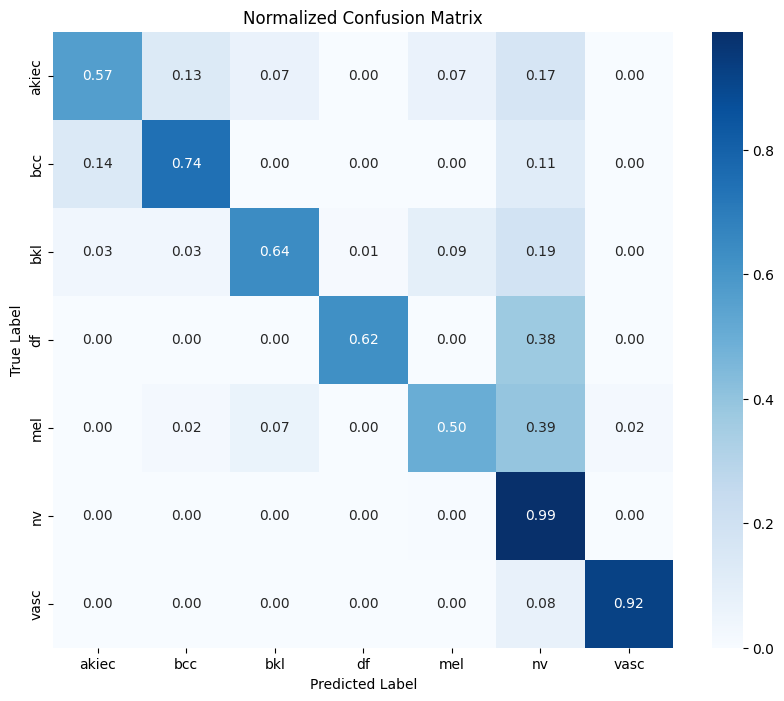

In [32]:
ef.group5_confusion_matrix(true_labels, pred_labels, class_list)